In [11]:
# import packages
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['axes.linewidth'] = 2

plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['legend.fontsize'] = 25


In [12]:
# import the data
bikes = pd.read_csv('train.csv', index_col=0, parse_dates=True)
bikes.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [13]:
# In order to include the correlations from timestamp I will introduce new columns:
bikes['hour'] = bikes.index.hour
bikes['day'] = bikes.index.day
bikes['month'] = bikes.index.month
bikes['year'] = bikes.index.year
bikes['year_span'] = bikes['month']+(bikes['year']-2011)*12
bikes.insert(15, 'count', bikes.pop('count'))
bikes.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,hour,day,month,year,year_span,count
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,0,1,1,2011,1,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,1,1,1,2011,1,40


# 2. Exploratory Data Analysis + Feature Engineering

# Separate notebook was created for the expolration of the data.
- bike_EDA

# Make the pipeline

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Lasso 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
import pandas as pd
import os
print(os.getcwd())

/Users/alexandros.samartzis/Spiced_Academy/stationary-sriracha-student-code/week_3/spiced_porojects


In [15]:
bikes.drop(['temp','registered','casual','year'],axis=1,inplace=True)
bikes.head(2)

,season,holiday,workingday,weather,atemp,humidity,windspeed,hour,day,month,year_span,count
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0,0,1,1,1,16
2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0,1,1,1,1,40


In [16]:
# split to X, and y
X = bikes.iloc[:,:11]
y = bikes['count']# feature engineering for numericals
X.head(1)

,season,holiday,workingday,weather,atemp,humidity,windspeed,hour,day,month,year_span
datetime,,,,,,,,,,,
2011-01-01,1,0,0,1,14.395,81,0.0,0,1,1,1


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42) 

datetime
2012-05-02 07:00:00    358
Name: count, dtype: int64

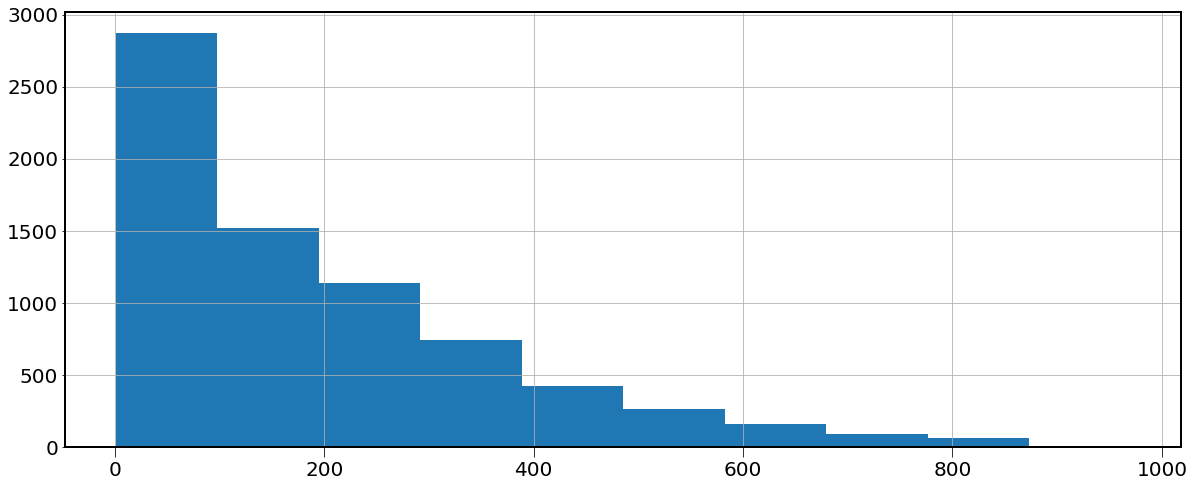

In [18]:
y_train.hist()
y_train.tail(1)

# Transform the Count variable: 
### We use a logarithmic transformation to optimize the target's distribution. Idealy a normal distribution for linear models.

* In this way we also make sure we do not predict negative counts

In [19]:
ylog_train = np.log1p(y_train)
ylog_test = np.log1p(y_test)

<AxesSubplot:>

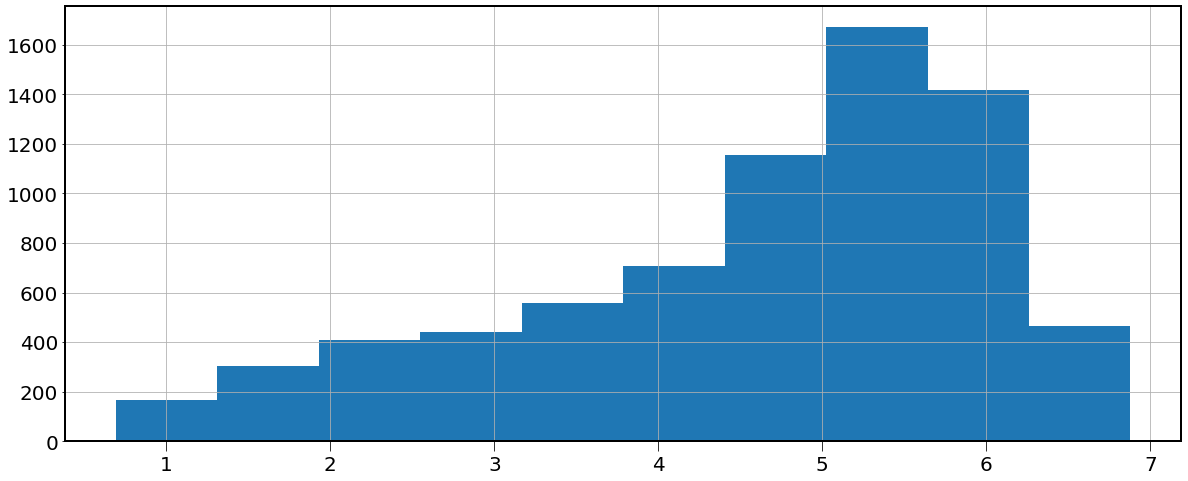

In [20]:
ylog_train.hist()

- Data transformations
- -  Make the pipelines

In [21]:
numerical_pipeline = Pipeline([
    ('num_scaler',StandardScaler()),
    ('polynomial', PolynomialFeatures(degree= 3, include_bias=False)),

])

In [22]:
categorical_pipeline = Pipeline([
    ('categorical_ohe',OneHotEncoder(sparse=False, drop='first',)),
])

In [23]:
polynomial_pipeline_3 = Pipeline([
    ('polynomial', PolynomialFeatures(degree= 3,)),
])

In [24]:
polynomial_pipeline_4 = Pipeline([
    ('polynomial', PolynomialFeatures(degree= 4,)),
])

In [27]:
column_transformer = ColumnTransformer([
    ('numerical_pipeline_a',numerical_pipeline,['atemp','humidity','windspeed' ]),      
    ('polynomial_3', polynomial_pipeline_3, ['hour',]),                  
    ('polynomial_4', polynomial_pipeline_4, ['month','year_span']),                                       
    ('categorical_pipeline',categorical_pipeline,[ 'season', 'workingday', 'holiday', 'weather','day'])
])

In [28]:
bikes.head(1)

,season,holiday,workingday,weather,atemp,humidity,windspeed,hour,day,month,year_span,count
datetime,,,,,,,,,,,,
2011-01-01,1,0,0,1,14.395,81,0.0,0,1,1,1,16


In [29]:
column_transformer.fit(X_train) 
X_train_no_int = column_transformer.transform(X_train) 
X_test_no_int = column_transformer.transform(X_test)

In [30]:
df_no_int=pd.DataFrame(X_train_no_int, columns=column_transformer.get_feature_names_out())
df_no_int.columns

Index(['numerical_pipeline_a__atemp', 'numerical_pipeline_a__humidity',
       'numerical_pipeline_a__windspeed', 'numerical_pipeline_a__atemp^2',
       'numerical_pipeline_a__atemp humidity',
       'numerical_pipeline_a__atemp windspeed',
       'numerical_pipeline_a__humidity^2',
       'numerical_pipeline_a__humidity windspeed',
       'numerical_pipeline_a__windspeed^2', 'numerical_pipeline_a__atemp^3',
       'numerical_pipeline_a__atemp^2 humidity',
       'numerical_pipeline_a__atemp^2 windspeed',
       'numerical_pipeline_a__atemp humidity^2',
       'numerical_pipeline_a__atemp humidity windspeed',
       'numerical_pipeline_a__atemp windspeed^2',
       'numerical_pipeline_a__humidity^3',
       'numerical_pipeline_a__humidity^2 windspeed',
       'numerical_pipeline_a__humidity windspeed^2',
       'numerical_pipeline_a__windspeed^3', 'polynomial_3__1',
       'polynomial_3__hour', 'polynomial_3__hour^2', 'polynomial_3__hour^3',
       'polynomial_4__1', 'polynomial_4__mo

In [37]:
m = LinearRegression()
m.fit(X_train_no_int,ylog_train)
m.score(X_train_no_int,ylog_train)

0.6713508098904147

In [38]:
m.score(X_test_no_int,ylog_test)

0.6592508574302313

In [39]:
y_predlog = m.predict(X_test_no_int)

In [40]:
ypred = np.exp(y_predlog)-1

-Kaggle

In [ ]:
df_k = pd.read_csv('test.csv', index_col=0, parse_dates=True)
df_k.shape